In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
import scipy
from subprocess import call
from IPython.display import Image
from sklearn.model_selection import train_test_split
from scipy import stats

%matplotlib inline
matplotlib.style.use('bmh')

data_all_thomas = pd.read_excel('../annotations/data_all_thomas.xlsx')
data_labels_video_features = pd.read_csv('../annotations/combined_labels_video_features.csv')
labels = data_labels_video_features[['gold_gt_max_aro','gold_gt_max_like','gold_gt_max_val','gold_gt_min_aro','gold_gt_min_like','gold_gt_min_val']]
fusion_labels_weighted = pd.read_csv('fold_cv_hard_labels_weighted_zn_l2.csv')
#labels_max = labels[['gold_gt_max_aro','gold_gt_max_like','gold_gt_max_val']]
#labels_min = labels[['gold_gt_min_aro','gold_gt_min_like','gold_gt_min_val']]


In [3]:
# Set video features, No Normalization
video_features = data_labels_video_features.drop(['gold_gt_max_aro','gold_gt_max_like','gold_gt_max_val','gold_gt_min_aro','gold_gt_min_like','gold_gt_min_val'],axis=1)

In [4]:
# Applying z normalization
video_features = video_features.apply(stats.zscore)

In [5]:
# Applying L2 normalization
video_features = pd.DataFrame(sk.preprocessing.normalize(video_features, norm='l2',axis=1))

In [ ]:
# Splitting and converting train and test data
X_train, X_test, y_train, y_test = train_test_split(video_features, data_all_thomas.agreeableness_binary, train_size=440,test_size=220,shuffle=False)


X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [27]:
# 3 Fold Cross Validation KELM
from sklearn.model_selection import KFold
import kernel_elm as elm
from sklearn.metrics import recall_score


variables_fold = [data_all_thomas.interview_binary[:660], data_all_thomas.agreeableness_binary[:660], data_all_thomas.openness_binary[:660], data_all_thomas.neuroticism_binary[:660], data_all_thomas.extraversion_binary[:660], data_all_thomas.conscientiousness_binary[:660], data_all_thomas.arousal[:660], data_all_thomas.valence[:660], data_all_thomas.likeability[:660]]
hyperparams_c = [100000,10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

predictions_folds_660 = pd.DataFrame()
predictions_test_set = pd.DataFrame()

best_c = [100,100,1000,1000,100,10,100,100,100,10000,10000,10000,100,100,1000,1000,10,100000,100,100,100,1000,10,10,1,1000,1]

for index, variable in enumerate(variables_fold, 0):
    kfold = KFold(3,False,None)
    name = variable.name
    variable = variable.to_numpy()
    predictions_fold = []

    for index_fold, (train_index, test_index) in enumerate(kfold.split(variable),(index * 3)):
        # Create ELM
        kelm = elm.Extreme_Learning_Machine(kernel="linear",weighted=True,C=best_c[index_fold], model_type="classification")
        # Create train and tests sets
        X_train, X_test = video_features.iloc[train_index].to_numpy(), video_features.iloc[test_index].to_numpy()
        y_train, y_test = variable[train_index], variable[test_index]
        # Train model
        kelm.train(X_train, y_train)
        # 220 predicions test set
        y_predict_fold = kelm.test(X_test)
        # 300 Predictions bottom feature set (used as test set later, with voting)
        y_predict_test_set = kelm.test(video_features[660:].to_numpy())
        # Compute fold score (for checking if correct model)
        fold_score = recall_score(y_test, y_predict_fold,average='macro')  
        # Add fold prediction to list
        predictions_fold = predictions_fold + y_predict_fold
        predictions_test_set[name +"_"+ str(index_fold)] = [fold_score] + y_predict_test_set


    # Add prediction of dimension to dataframe as column, should create 9 columns (1 per dimension)
    predictions_folds_660[index] = [name] + predictions_fold
    

In [28]:
predictions_folds_660.to_csv('predictions_folds_660.csv')
predictions_test_set.to_csv('predictions_test_set.csv')

In [25]:
from sklearn.model_selection import KFold


kfold = KFold(3,False,None)
for train, test in kfold.split(data_all_thomas.valence[:660]):
    print(test)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219]
[220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 

In [ ]:
# Create dataframe to store predictions
report_3_model = pd.DataFrame()

In [ ]:
# 3 Model fusion
import kernel_elm as elm
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

# Dimensions to use
variables_fold = pd.DataFrame([data_all_thomas.interview_binary[:660], data_all_thomas.agreeableness_binary[:660], data_all_thomas.openness_binary[:660], data_all_thomas.neuroticism_binary[:660], data_all_thomas.extraversion_binary[:660], data_all_thomas.conscientiousness_binary[:660], data_all_thomas.arousal[:660], data_all_thomas.valence[:660], data_all_thomas.likeability[:660]]).transpose()

# Choose dimension
dimension = variables_fold.likeability

# Best C params, dimension and fold specific
hyperparams_c = [
1,
1000,
1
]

# Create fold
kfold = KFold(3,False,None)

# Loop through folds
for index, (train_index, test_index) in enumerate(kfold.split(dimension)):
    # Loop through hyperparam, in order of fold (check csv)
    kelm = elm.Extreme_Learning_Machine(kernel="linear",weighted=True,C=hyperparams_c[index], model_type="classification")
    X_train, X_test = video_features.iloc[train_index].to_numpy(), video_features.iloc[test_index].to_numpy()
    y_train, y_test = dimension[train_index].to_numpy(), dimension[test_index].to_numpy()
    kelm.train(X_train, y_train)
    # Get predictions of single fold (to check if correct model)
    y_prediction_fold = kelm.test(X_test)
    fold_score = recall_score(y_test, y_prediction_fold, average="macro")
    # Get predictions of 660 rows, creates test set per fold model
    y_predictions_all = kelm.test(video_features.iloc[:660].to_numpy())   
    report_3_model[dimension.name +"_"+ str(index)] = [fold_score] + y_predictions_all


In [ ]:
# Save to csv
report_3_model.to_csv('report_3_fold_weighted_train_output.csv')

In [ ]:
# Single ELM
import kernel_elm as elm
from sklearn.metrics import classification_report, confusion_matrix,recall_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

elmk = elm.Extreme_Learning_Machine(kernel="linear",weighted=False,C=1, model_type="classification")
beta = elmk.train(X_train,y_train)
y_predict = elmk.test(X_test)
#recall_score(y_test, y_predict,average='macro')
#mean_squared_error(y_test,y_predict,squared=False)
#mean_absolute_error(y_test,y_predict)


In [ ]:
# Decision Tree pre-processing
# Converting categorical variables to one-hot encoding
arousal_dummy = pd.get_dummies(data_all_thomas[['arousal']].astype(str))[:660].to_numpy()
valence_dummy = pd.get_dummies(data_all_thomas[['valence']].astype(str))[:660].to_numpy()
likeability_dummy = pd.get_dummies(data_all_thomas[['likeability']].astype(str))[:660].to_numpy()

arousal_weighted = arousal_dummy * beta_arousal
valence_weighted = valence_dummy * beta_valence
likeability_weighted = likeability_dummy * beta_likeability

x_train_mood_weighted_categorical = np.concatenate((arousal_weighted, valence_weighted, likeability_weighted), axis=1)


In [ ]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


x_train_bin = data_all_thomas[['agreeableness_binary','conscientiousness_binary','extraversion_binary','neuroticism_binary','openness_binary']]
y_train_bin = data_all_thomas[['interview_binary']][:660]

rf = RandomForestClassifier(n_estimators=100, bootstrap=True, max_features='sqrt', max_depth=4)
rf.fit(x_train_mood_weighted_categorical,y_train_bin)

In [12]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix,recall_score


person_bin = data_all_thomas[['agreeableness_binary','conscientiousness_binary','extraversion_binary','neuroticism_binary','openness_binary']]
mood_cat = data_all_thomas[['arousal','valence','likeability']]
mood_person_combined = data_all_thomas[['agreeableness_binary','openness_binary','neuroticism_binary','extraversion_binary','conscientiousness_binary','arousal','valence','likeability']]
interview_bin = data_all_thomas[['interview_binary']]

X_train, y_train = fusion_labels_weighted.drop(['interview_binary_0'], axis=1) , fusion_labels_weighted.interview_binary_0
X_test, y_test = mood_person_combined[660:], interview_bin[660:]

clf = DecisionTreeClassifier(random_state=None, max_depth=9, min_samples_leaf=20)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
recall_score(y_test, y_predict, average="macro")

0.8338414634146342

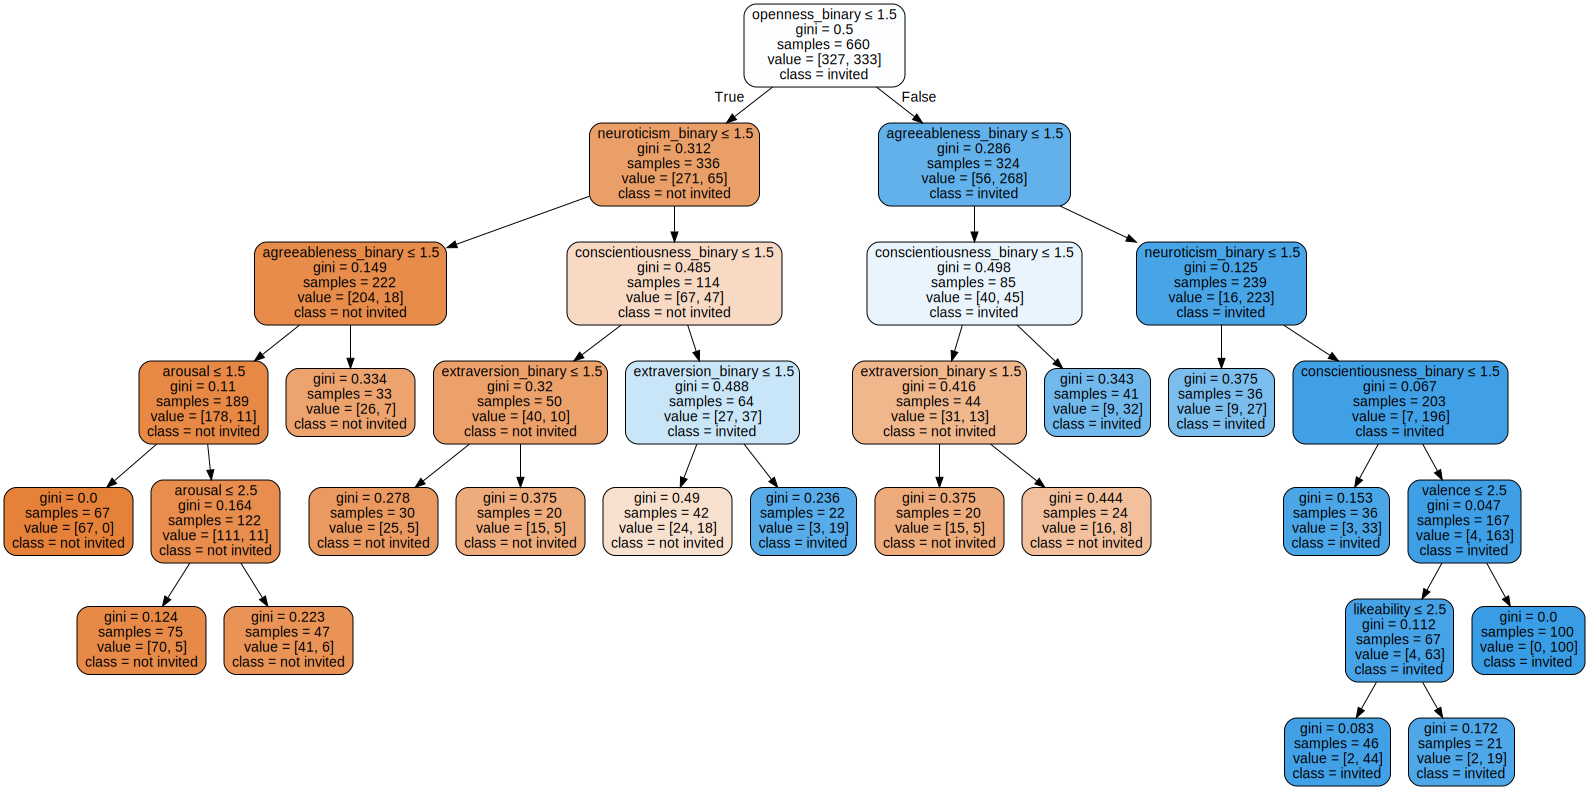

In [13]:
# Generete dot file for tree and visualize using graphviz
import graphviz 


dot_data = tree.export_graphviz(clf, out_file=None,feature_names=mood_person_combined.columns,class_names=['not invited','invited'],filled=True, rounded=True,special_characters=True)  
graph = graphviz.Source(dot_data)
graph 

In [ ]:
# Multiple ELM
import kernel_elm as elm
from sklearn.metrics import classification_report, confusion_matrix,recall_score


variables_mood = [labels['gold_gt_min_aro'],labels['gold_gt_min_like'],labels['gold_gt_min_val'],data_all_thomas['arousal'],data_all_thomas['likeability'],data_all_thomas['valence']]
variables_personality_binary = [data_all_thomas.agreeableness_binary, data_all_thomas.conscientiousness_binary, data_all_thomas.extraversion_binary, data_all_thomas.neuroticism_binary, data_all_thomas.openness_binary, data_all_thomas.interview_binary]
variables_personality_continuous = [data_all_thomas.agreeableness, data_all_thomas.conscientiousness, data_all_thomas.extraversion, data_all_thomas.neuroticism, data_all_thomas.openness, data_all_thomas.interview]

hyperparams_c = [100000,10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]
gammas = [100,10,1,0.1,0.01,0.001,0.0001,0.00001,0.000001]
weights = [True, False]

report_kelms = pd.DataFrame(columns=['variable'] + hyperparams_c)

for weight in weights:
    for variable in variables_personality_binary:
        row = [str(weight) + ' - ' + variable.name]
        for c_var in hyperparams_c:
            X_train, X_test, y_train, y_test = train_test_split(video_features, variable, train_size=660,test_size=300,shuffle=False)
            X_train = X_train.to_numpy()
            X_test = X_test.to_numpy()
            y_train = y_train.to_numpy()
            y_test = y_test.to_numpy()
            kelm = elm.Extreme_Learning_Machine(C=c_var, kernel='linear', weighted=weight, model_type="classification")
            kelm.train(X_train,y_train)
            y_pred_single = kelm.test(X_test)
            row = row + [recall_score(y_test, y_pred_single,average='macro')]
        report_kelms = report_kelms.append(pd.Series(row,index=report_kelms.columns),ignore_index=True)


report_kelms.to_csv('report_personality_kelm_linear_weighted_c_binary_l2.csv')

In [ ]:
# Multiple ELM 